In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [31]:
import mlflow
# set the tracking URI to the MLflow server
mlflow.set_tracking_uri("http://0.0.0.0:5000") # tells mlflow where the tracking server
mlflow.set_experiment("nyc-taxi") # # creates or selects an experiment to log runs (like training ,metrics,models)

2025/05/26 15:27:26 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow/3', creation_time=1748273246641, experiment_id='3', last_update_time=1748273246641, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [3]:
def read_data_frame(file_path):
    df=pd.read_parquet(file_path)

    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda x:x.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df
    
    

In [4]:
df_train=read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73908 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               73908 non-null  int64         
 1   lpep_pickup_datetime   73908 non-null  datetime64[us]
 2   lpep_dropoff_datetime  73908 non-null  datetime64[us]
 3   store_and_fwd_flag     38175 non-null  object        
 4   RatecodeID             38175 non-null  float64       
 5   PULocationID           73908 non-null  object        
 6   DOLocationID           73908 non-null  object        
 7   passenger_count        38175 non-null  float64       
 8   trip_distance          73908 non-null  float64       
 9   fare_amount            73908 non-null  float64       
 10  extra                  73908 non-null  float64       
 11  mta_tax                73908 non-null  float64       
 12  tip_amount             73908 non-null  float64       
 13  tolls_

In [6]:
'''cat_col=df_train.select_dtypes(include='object')
   num_col=df_train.select_dtypes(exclude='object')'''

"cat_col=df_train.select_dtypes(include='object')\n   num_col=df_train.select_dtypes(exclude='object')"

In [7]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/tmp/ipykernel_171/55724668.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)


<Axes: xlabel='duration', ylabel='Density'>

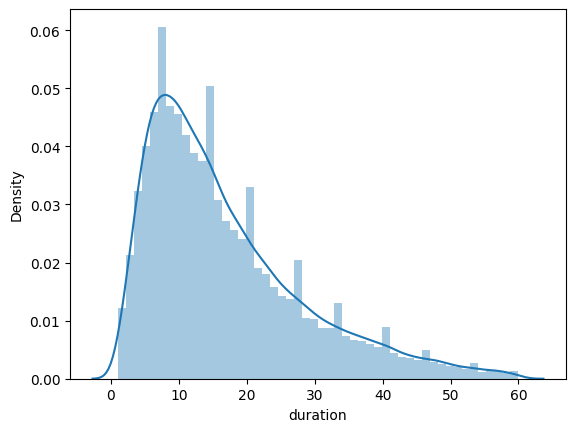

In [8]:
sns.distplot(df_train.duration)

In [9]:
df_train.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [10]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [11]:
df_train.duration.describe(percentiles=[.95,.98,.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [12]:
cat_cols = ['PULocationID', 'DOLocationID']
num_cols = ['trip_distance']
train_dicts=df_train[cat_cols+num_cols].to_dict(orient='records')
dv=DictVectorizer()
x_train=dv.fit_transform(train_dicts)
target='duration'
y_train=df_train[target].values
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_train)
mse=mean_squared_error(y_train, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(9.838799799829628)

/tmp/ipykernel_171/1877227026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_171/1877227026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


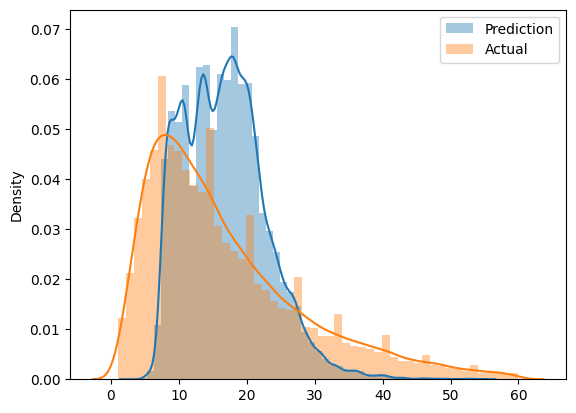

In [13]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [14]:
df_train['PU_DO']=df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
cat_col=['PU_DO']
num_col=['trip_distance']
dv=DictVectorizer()
train_dicts=df_train[cat_col+num_col].to_dict(orient='records')
x_train=dv.fit_transform(train_dicts)
val_dicts = df_val[cat_col + num_col].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [16]:
target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [34]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(7.758715205596356)

In [44]:
os.makedirs('Models',exist_ok=True)
with open('Models/lin_rdge.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [38]:
with mlflow.start_run(): # starts logging a new ml run
    mlflow.set_tag('developer', 'Ebrahim Emad Abdallah') # add a tag to describe the run

    # log the paths to the training and validation data
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param('alpha', alpha) # logs the hyperparameter alpha for the Lasso model
    lr=Lasso(alpha=alpha) # trains a Lasso regression model with the specified alpha
    lr.fit(x_train, y_train) # fits the model to the training data
    y_pred = lr.predict(x_val) # predicts the target variable for the validation set
    mse = mean_squared_error(y_val, y_pred) # calculates the mean squared error between the predicted and actual values
    rmse = np.sqrt(mse)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path='Models/rdge.bin', artifact_path='models_pickle') # logs the trained model as an artifact

    

🏃 View run puzzled-moth-640 at: http://0.0.0.0:5000/#/experiments/3/runs/f58e2a29a2864b958bc456e058a876f6
🧪 View experiment at: http://0.0.0.0:5000/#/experiments/3


In [39]:
lr=Ridge()
lr.fit(x_train,y_train)

y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

np.float64(7.703735147161527)

In [45]:
os.makedirs('Models',exist_ok=True)
with open('Models/rdge.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [42]:
import xgboost as xgb
# use XGBoost's DMatrix :: which is a special data structure optimized for speed and memory
# convert the training and validation data into DMatrix format
train=xgb.DMatrix(x_train, label=y_train) 
valid=xgb.DMatrix(x_val, label=y_val)

In [46]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model','xgboost')
        mlflow.log_params(params)


        booster=xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred=booster.predict(valid)
        mse=mean_squared_error(y_val, y_pred)
        rmse=np.sqrt(mse)
        mlflow.log_metric('rmse', rmse)
    return {'loss':rmse, 'status': STATUS_OK}

In [50]:

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # Range between exp(-3), and exp(0) == [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lamda': hp.loguniform('reg_lamda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:54:42] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:54:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.44287                           
[1]	validation-rmse:8.01034                           
[2]	validation-rmse:7.30632                           
[3]	validation-rmse:6.96656                           
[4]	validation-rmse:6.79156                           
[5]	validation-rmse:6.70054                           
[6]	validation-rmse:6.64469                           
[7]	validation-rmse:6.61211                           
[8]	validation-rmse:6.59331                           
[9]	validation-rmse:6.57807                           
[10]	validation-rmse:6.56805                          
[11]	validation-rmse:6.55423                          
[12]	validation-rmse:6.54721                          
[13]	validation-rmse:6.53989                          
[14]	validation-rmse:6.53790                          
[15]	validation-rmse:6.53570                          
[16]	validation-rmse:6.53336                          
[17]	validation-rmse:6.53151                          
[18]	valid

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:55:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:55:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:7.21260                                                    
[7]	validation-rmse:7.08092                                                    
[8]	validation-rmse:6.98894                                                    
[9]	validation-rmse:6.92384                                                    
[10]	validation-rmse:6.87784                                                   
[11]	validation-rmse:6.84504                                                   
[12]	validation-rmse:6.82100                                                   
[13]	validation-rmse:6.80091                                                   
[14]	validation-rmse:6.78616                                                   
[15]	validation-rmse:6.77485                                                   
[16]	validation-rmse:6.76759                                                   
[17]	validation-rmse:6.76100                                                   
[18]	validation-rmse:6.75477            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:55:29] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.68247                                                    
[1]	validation-rmse:6.62847                                                    
[2]	validation-rmse:6.61244                                                    
[3]	validation-rmse:6.59697                                                    
[4]	validation-rmse:6.59157                                                    
[5]	validation-rmse:6.58082                                                    
[6]	validation-rmse:6.57262                                                    
[7]	validation-rmse:6.56387                                                    
[8]	validation-rmse:6.55822                                                    
[9]	validation-rmse:6.54652                                                    
[10]	validation-rmse:6.54430                                                   
[11]	validation-rmse:6.53801                                                   
[12]	validation-rmse:6.53610            

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:55:41] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:55:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.34852                                                    
[1]	validation-rmse:9.04241                                                     
[2]	validation-rmse:8.15990                                                     
[3]	validation-rmse:7.59164                                                     
[4]	validation-rmse:7.21795                                                     
[5]	validation-rmse:6.98715                                                     
[6]	validation-rmse:6.83686                                                     
[7]	validation-rmse:6.73855                                                     
[8]	validation-rmse:6.66664                                                     
[9]	validation-rmse:6.61497                                                     
[10]	validation-rmse:6.57976                                                    
[11]	validation-rmse:6.55192                                                    
[12]	validation-rmse:6.53750

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:56:31] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "reg_lamda" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.69469                                                   
[1]	validation-rmse:11.21984                                                   
[2]	validation-rmse:10.78530                                                   
[3]	validation-rmse:10.38828                                                   
[4]	validation-rmse:10.02608                                                   
[5]	validation-rmse:9.69667                                                    
[6]	validation-rmse:9.39691                                                    
[7]	validation-rmse:9.12497                                                    
[8]	validation-rmse:8.87891                                                    
[9]	validation-rmse:8.65619                                                    
[10]	validation-rmse:8.45466                                                   
[11]	validation-rmse:8.27263                                                   
[12]	validation-rmse:8.10835            

KeyboardInterrupt: 

In [51]:
mlflow.xgboost.autolog(disable=True)


In [ ]:

logged_model = 'runs:/e4bd2b98edb747f2b19e53d42861636d/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model


In [ ]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

xgboost_model

In [ ]:
y_pred = xgboost_model.predict(valid)

y_pred[:10]